# Tutorial 1.6: Sensitivity analysis

- **Authors**: Xiaoyu Xie
- **Contact**: xiaoyuxie2020@u.northwestern.edu

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/sensitive_analysis.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xiaoyuxie-vico/PyDimension-Book/HEAD)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from SALib.sample import saltelli
import seaborn as sns

%matplotlib inline
# plt.rcParams["font.family"] = 'Arial'

In [ ]:
# # please uncomment these two lines, if you run this code in Colab
# !git clone https://github.com/xiaoyuxie-vico/PyDimension-Book
# %cd PyDimension-Book/examples

## Helper functions

In [2]:
def parse_data(df, para_list, output='e*'):
    '''Parse the input and output parameters'''
    X = df[para_list].to_numpy()
    y = df[output].to_numpy()
    return X, y

def calculate_bounds(df, para_list):
    '''Calculate lower and upper bounds for each parameter'''
    bounds = []
    for var_name in para_list:
        bounds.append([df[var_name].min(), df[var_name].max()])
    return bounds

def train_model(X, y, coef_pi, deg):
    '''Build a predictive model with polynomial function'''
    # build features
    pi1 = np.prod(np.power(X, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
    poly = PolynomialFeatures(deg)
    pi1_poly = poly.fit_transform(pi1)
    
    # fit
    model = LinearRegression(fit_intercept=False)
    model.fit(pi1_poly, y)
    model.score(pi1_poly, y)
    return model, poly

def SA(para_list, coef_pi, bounds, model, poly, sample_num=2**10):
    '''Sensitivity analysis'''
    problem = {'num_vars': len(para_list), 'names': para_list, 'bounds': bounds}

    # Generate samples
    X_sampled = saltelli.sample(problem, sample_num, calc_second_order=True)
    pi1_sampled = np.prod(np.power(X_sampled, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
    pi1_sampled_poly = poly.transform(pi1_sampled)
    Y_sampled = model.predict(pi1_sampled_poly).reshape(-1,)
    print(Y_sampled.shape)

    # Perform analysis
    Si = sobol.analyze(problem, Y_sampled, print_to_console=True)
    
    return Si

def plot(Si, xtick_labels):
    '''Visualization'''
    total_Si, first_Si, second_Si = Si.to_df()
    
    total_Si['Type'] = ['Sobol total'] * total_Si.shape[0]
    total_Si = total_Si.rename(columns={'ST': 'Sensitivity', 'ST_conf': 'conf'})
    total_Si.index.name = 'Variable'
    total_Si.reset_index(inplace=True)

    first_Si['Type'] = ['Sobol 1st order'] * first_Si.shape[0]
    first_Si = first_Si.rename(columns={'S1': 'Sensitivity', 'S1_conf': 'conf'})
    first_Si.index.name = 'Variable'
    first_Si.reset_index(inplace=True)
    
    res_df = pd.concat([first_Si, total_Si]).reset_index(drop=False)
    # res_df = res_df.reindex(combined_df_index)
    
    fig = plt.figure()
    ax = sns.barplot(data=res_df, x='Variable', y='Sensitivity', hue='Type')
    ax.set_xticklabels(xtick_labels)
    ax.legend(fontsize=14)
    ax.set_xlabel('Variable', fontsize=16)
    ax.set_ylabel('Sensitivity', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=13)
    plt.tight_layout()


## Load keyhole dataset

In [3]:
# load data
df = pd.read_csv('../dataset/dataset_keyhole.csv')
df.describe()

etaP         Vs         r0      alpha          rho           cp  \
count   90.000000  90.000000  90.000000  90.000000    90.000000    90.000000   
mean   143.036444   0.733889   0.000053   0.000013  3949.633333   872.222222   
std     85.162496   0.267933   0.000010   0.000008   997.040085   117.939022   
min     31.400000   0.300000   0.000044   0.000005  2415.000000   790.000000   
25%     73.825000   0.600000   0.000047   0.000010  3920.000000   830.000000   
50%    120.160000   0.700000   0.000047   0.000010  3920.000000   830.000000   
75%    192.895000   1.000000   0.000066   0.000010  3920.000000   830.000000   
max    342.600000   1.200000   0.000070   0.000032  6881.000000  1170.000000   

             Tv-T0            Lv        Tl-T0             Lm          e  \
count    90.000000  9.000000e+01    90.000000      90.000000  90.000000   
mean   3130.533333  9.197967e+06  1480.044444  296511.111111   0.000173   
std     275.287641  9.413036e+05   342.642865   33657.309487   0.000129   
min    2499.000000  6.336000e+06   622.000000  260000.000000   0.000015   
25%    3267.000000  9.255000e+06  1630.000000  286000.000000   0.000071   
50%    3267.000000  9.255000e+06  1630.000000  286000.000000   0.000146   
75%    3267.000000  9.255000e+06  1630.000000  286000.000000   0.000252   
max    3267.000000  1.053000e+07  1630.000000  380000.000000   0.000562   

              Ke         e*  
count  90.000000  90.000000  
mean    9.981230   3.520206  
std     7.220693   2.799219  
min     1.545937   0.208731  
25%     4.197719   1.300126  
50%     7.947395   2.925625  
75%    14.359714   5.232955  
max    37.772286  12.772727

## Analysis for Ke

In [4]:
# config
para_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0']
coef_pi = np.array([1, -0.5, -1.5, -0.5, -1, -1, -1])  # for Ke
deg = 3

# choose parameters
X, y = parse_data(df, para_list)

# calculate bounds
bounds = calculate_bounds(df, para_list)

# train mdoel
model, poly = train_model(X, y, coef_pi, deg)

# calculate sensitivity
Si = SA(para_list, coef_pi, bounds, model, poly)

(16384,)
             ST   ST_conf
etaP   0.468911  0.050028
Vs     0.075444  0.009112
r0     0.086941  0.011356
alpha  0.137722  0.021253
rho    0.194494  0.022254
cp     0.026777  0.003437
Tl-T0  0.160593  0.022565
             S1   S1_conf
etaP   0.379400  0.051514
Vs     0.058095  0.022908
r0     0.061965  0.028293
alpha  0.110631  0.035521
rho    0.144342  0.041910
cp     0.018855  0.015755
Tl-T0  0.128264  0.033756
                      S2   S2_conf
(etaP, Vs)      0.008929  0.074473
(etaP, r0)      0.014155  0.070596
(etaP, alpha)   0.010734  0.075564
(etaP, rho)     0.042107  0.081427
(etaP, cp)      0.003964  0.067417
(etaP, Tl-T0)   0.018733  0.073171
(Vs, r0)       -0.003869  0.039997
(Vs, alpha)    -0.006055  0.040635
(Vs, rho)       0.000813  0.044087
(Vs, cp)       -0.007282  0.038450
(Vs, Tl-T0)    -0.000395  0.042943
(r0, alpha)     0.003093  0.051613
(r0, rho)      -0.001922  0.046057
(r0, cp)        0.002067  0.043302
(r0, Tl-T0)     0.001900  0.050467
(alpha, rho)   

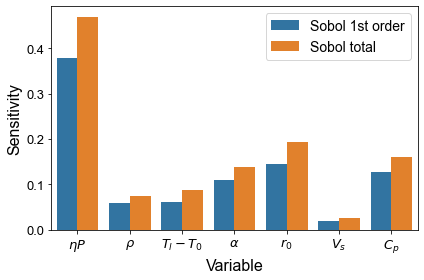

In [5]:
xtick_labels = [r'$\eta P$', r'$\rho$', r'$T_l-T_0$', r'$\alpha$', r'$r_0$', r'$V_s$', r'$C_p$']
# sort the sensitivity from high to low
# combined_df_index = [0, 4, 6, 3, 2, 1, 5, 0+7, 4+7, 6+7, 3+7, 2+7, 1+7, 5+7] 
plot(Si, xtick_labels)

## Add one more parameter $T_v-T_l$

In [6]:
# config
para_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0', 'Tv-T0']
coef_pi = np.array([1, -0.5, -1.5, -0.5, -1, -1, -0.75, -0.25])  # for table 3, 2nd row
deg = 3

# choose parameters
X, y = parse_data(df, para_list)

# calculate bounds
bounds = calculate_bounds(df, para_list)

# train mdoel
model, poly = train_model(X, y, coef_pi, deg)

# calculate sensitivity
Si = SA(para_list, coef_pi, bounds, model, poly)

(18432,)
             ST   ST_conf
etaP   0.435631  0.141921
Vs     0.102755  0.023126
r0     0.101415  0.029895
alpha  0.216431  0.062993
rho    0.243284  0.089015
cp     0.029825  0.007285
Tl-T0  0.154469  0.093794
Tv-T0  0.001798  0.001038
             S1   S1_conf
etaP   0.293056  0.087926
Vs     0.058431  0.027904
r0     0.060356  0.028596
alpha  0.111009  0.040648
rho    0.143368  0.048024
cp     0.017399  0.010429
Tl-T0  0.059561  0.030725
Tv-T0  0.000351  0.002297
                      S2   S2_conf
(etaP, Vs)      0.001401  0.075203
(etaP, r0)     -0.004557  0.070189
(etaP, alpha)   0.022270  0.083248
(etaP, rho)     0.009413  0.075464
(etaP, cp)     -0.011741  0.067327
(etaP, Tl-T0)   0.010808  0.084122
(etaP, Tv-T0)  -0.008894  0.069034
(Vs, r0)       -0.008851  0.053538
(Vs, alpha)    -0.008343  0.070181
(Vs, rho)      -0.010061  0.058046
(Vs, cp)       -0.009823  0.048538
(Vs, Tl-T0)    -0.006326  0.062941
(Vs, Tv-T0)    -0.009010  0.048977
(r0, alpha)    -0.013241  0.05815

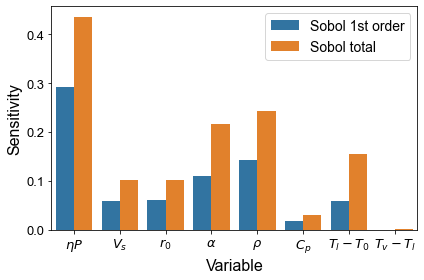

In [7]:
xtick_labels = [r'$\eta P$', r'$V_s$', r'$r_0$', r'$\alpha$', r'$\rho$',
                    r'$C_p$', r'$T_l-T_0$', r'$T_v-T_l$']
plot(Si, xtick_labels)

## Add one more parameter $L_m$

In [8]:
# config
para_list = ['etaP', 'Vs', 'r0', 'alpha', 'rho', 'cp', 'Tl-T0', 'Lm']
coef_pi = np.array([1, -0.5, -1.5, -0.5, -1, -0.75, -0.75, -0.25])  # for table 4, 3rd row
deg = 3

# choose parameters
X, y = parse_data(df, para_list)

# calculate bounds
bounds = calculate_bounds(df, para_list)

# train mdoel
model, poly = train_model(X, y, coef_pi, deg)

# calculate sensitivity
Si = SA(para_list, coef_pi, bounds, model, poly)

(18432,)
             ST   ST_conf
etaP   0.407922  0.176609
Vs     0.114861  0.041686
r0     0.109062  0.047418
alpha  0.253861  0.104101
rho    0.295320  0.210374
cp     0.018771  0.007139
Tl-T0  0.216055  0.203684
Lm     0.005355  0.003846
             S1   S1_conf
etaP   0.246249  0.091998
Vs     0.053234  0.029041
r0     0.051079  0.032345
alpha  0.101483  0.040978
rho    0.127977  0.065370
cp     0.008455  0.009655
Tl-T0  0.051638  0.028950
Lm     0.000703  0.004013
                      S2   S2_conf
(etaP, Vs)     -0.001122  0.060090
(etaP, r0)     -0.008193  0.064461
(etaP, alpha)   0.019447  0.077966
(etaP, rho)     0.006793  0.078096
(etaP, cp)     -0.014905  0.060690
(etaP, Tl-T0)   0.011559  0.080358
(etaP, Lm)     -0.010896  0.061241
(Vs, r0)       -0.011737  0.053514
(Vs, alpha)    -0.012059  0.073784
(Vs, rho)      -0.014467  0.058365
(Vs, cp)       -0.012331  0.048235
(Vs, Tl-T0)    -0.009250  0.061419
(Vs, Lm)       -0.011251  0.047862
(r0, alpha)    -0.008149  0.05382

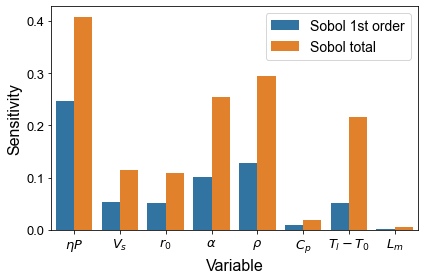

In [9]:
xtick_labels = [r'$\eta P$', r'$V_s$', r'$r_0$', r'$\alpha$', r'$\rho$',
                    r'$C_p$', r'$T_l-T_0$', r'$L_m$']
plot(Si, xtick_labels)